# Model

## Requirements

- import libraries

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    f1_score,
    log_loss,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

- functions

In [127]:
def get_data_schema(df: pd.DataFrame) -> dict:
    """
        `get_data_schema` generates data schema of a given dataframe.

        Parameters
        ----------
        df: `DataFrame`
            input dataset    

        Returns
        -------
        schema: `dict`
            required data schema in a `dict` where `keys` are COLUMN_NAMEs,\r
                and `values` are DATA TYPE.\    
        -----

        """
    schema = {}
    for col in df.columns:
        copy_df = df[[col]].copy()
        copy_df = copy_df[copy_df.isnull().any(axis=1) == False].head(1)
        schema[col] = "object"
        if copy_df.shape[0] == 0:
            continue
        schema[col] = str(copy_df.dtypes[0])
        if schema[col] != "object":
            continue
        if (
            pd.to_numeric(copy_df[col], errors="coerce", downcast="integer")
            .notnull()
            .all()
        ):
            schema[col] = "int64"
        elif (
            pd.to_numeric(copy_df[col], errors="coerce", downcast="float")
            .notnull()
            .all()
        ):
            schema[col] = "float64"
        elif pd.to_datetime(df[col], errors="coerce").notnull().all():
            schema[col] = "datetime64"

    return schema


def summarize_data(df, columns=None, n_visible_columns=10):
    def sum_data(df, col_name, is_date=False, is_cat=False):
        data = df[col_name].values
        n_digit = 2
        n = len(data)
        fig, ax = plt.subplots(1, 2, figsize=(6, 2.5))
        fig.subplots_adjust(wspace=0, top=1, right=1, left=0, bottom=0)
        if is_cat:
            in_valid = ["", "nan", "NA", "NULL", "None"]
            data = data.astype("str")
            is_null = np.in1d(data.astype("str"), in_valid)
            data[is_null] = "nan"
            unique_values, value_counts = np.unique(data, return_counts=True)
            index = np.argsort(value_counts)[::-1]
            unique_values, value_counts = (
                unique_values[index],
                value_counts[index],
            )

            if len(unique_values) > n_visible_columns:
                unique_values = np.append(unique_values[:n_visible_columns], "other")
                value_counts = np.append(
                    value_counts[:n_visible_columns],
                    value_counts[n_visible_columns:].sum(),
                )
            sum_df = {
                "Size": n,
                "Distinct": len(np.unique(data)),
                "Missing %": round(100 * is_null.sum() / n, n_digit),
            }
            for i, val in enumerate(unique_values[:5]):
                sum_df["{} %".format(val)] = round(100 * value_counts[i] / n, n_digit)

            ax[1].barh(unique_values, value_counts)
            ax[1].set_ylabel(col_name)
        elif is_date:
            data_num = data.astype("int64")
            sum_df = {
                "Size": n,
                "Distinct": len(np.unique(data)),
                "Missing %": round(100 * np.isnat(data).sum() / n, n_digit),
                "Zeros %": round(100 * (data_num == 0).sum() / n, n_digit),
                "Mean": np.datetime_as_string(
                    np.datetime64(int(np.nanmean(data_num)), "ns"), "D"
                ),
                "Median": np.datetime_as_string(
                    np.datetime64(int(np.nanmedian(data_num)), "ns"), "D"
                ),
                "Range": [
                    np.datetime_as_string(
                        np.datetime64(int(np.nanmin(data)), "ns"), "D"
                    ),
                    np.datetime_as_string(
                        np.datetime64(int(np.nanmax(data)), "ns"), "D"
                    ),
                ],
                "IQR": [
                    np.datetime_as_string(
                        np.datetime64(int(np.nanpercentile(data_num, 25)), "ns"), "D"
                    ),
                    np.datetime_as_string(
                        np.datetime64(int(np.nanpercentile(data_num, 75)), "ns"), "D"
                    ),
                ],
                "95 % CI": [
                    np.datetime_as_string(
                        np.datetime64(int(np.nanpercentile(data_num, 2.5)), "ns"), "D"
                    ),
                    np.datetime_as_string(
                        np.datetime64(int(np.nanpercentile(data_num, 97.5)), "ns"), "D"
                    ),
                ],
            }
            ax[1].hist(data, 20, edgecolor="white")
            ax[1].set_xlabel(col_name)
        else:
            sum_df = {
                "Size": n,
                "Distinct": len(np.unique(data)),
                "Missing %": round(100 * np.isnan(data).sum() / n, n_digit),
                "Zeros %": round(100 * (data.astype("float") == 0).sum() / n, n_digit),
                "Mean": round(np.nanmean(data), n_digit),
                "Median": round(np.nanmedian(data), n_digit),
                "St. Dev.": round(np.nanstd(data), n_digit),
                "Range": [
                    round(np.nanmin(data), n_digit),
                    round(np.nanmax(data), n_digit),
                ],
                "IQR": [
                    round(np.nanpercentile(data, 25), n_digit),
                    round(np.nanpercentile(data, 75), n_digit),
                ],
                "95 % CI": [
                    round(np.nanpercentile(data, 2.5), n_digit),
                    round(np.nanpercentile(data, 97.5), n_digit),
                ],
            }
            ax[1].hist(data, 20, edgecolor="white")
            ax[1].set_xlabel(col_name)

        the_table = ax[0].table(
            cellText=list(sum_df.items()),
            colLabels=["metric", "value"],
            bbox=[0.0, 0.0, 0.75, 1],
        )
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(9)
        the_table.auto_set_column_width(col=[0])
        # Hide the box border
        for key, cell in the_table._cells.items():
            cell.set_linestyle("-")
            cell.set_edgecolor("gray")
            cell.set_linewidth(0.5)
        ax[0].axis("off")
        ax[0].axis("tight")
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.show()

    df = df.copy()
    if columns == None:
        columns = df.columns
    datetime_columns = df.select_dtypes(include=["datetime64", "<M8"]).columns.tolist()
    categorical_columns = df.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()

    for col_name in columns:
        if (
            df[col_name].dtype not in categorical_columns
            and len(df[col_name].unique()) < 10
        ):
            categorical_columns.append(col_name)
            df[col_name] = df[col_name].astype("category")
        data = df[col_name].values
        sum_data(
            df,
            col_name,
            is_cat=(col_name in categorical_columns),
            is_date=(col_name in datetime_columns),
        )
    
def xy_violinplot(df: pd.DataFrame, target: str, feature: str) -> None:
    _, ax = plt.subplots()
    sns.violinplot(data=df, x=target, y=feature, ax=ax, orient="v")
    plt.show()


def xy_barplot(
    df: pd.DataFrame, target: str, features, top_k=20, percentage=False
):
    by = features + [target]
    sum_df = df.groupby(by).size().nlargest(top_k).unstack()

    _, ax = plt.subplots()
    if percentage:
        sum_df.apply(lambda x: x / x.sum(), axis=1).plot(
            kind="bar", stacked=True, ax=ax
        )
        ax.set_ylabel("percentage")
    else:
        sum_df.plot(kind="bar", stacked=True, ax=ax)
        ax.set_ylabel("frequency")

    plt.show()


def xy_scatterplot(df: pd.DataFrame, x_col: str, y_col: str, color=None) -> None:

    _, ax = plt.subplots()
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=color)

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    plt.title("")
    plt.suptitle("")
    plt.show()


def feature_importance(
    x: np.array,
    y: np.array,
    features,
    top_k: int = 20,
    is_classifer: bool = False,
    verbos=True,
) -> pd.DataFrame:
    """
    `feature_importance` gives x and y datasets and returns feature importance

    Parameters
    ----------
    x: `np.array`
        x dataset.
    y: `np.array`
        y dataset.
    features: `list[str]`
        list of features
    top_k: `int`
        top k features, users want to have in output plot. By default is 20
    is_classifer: `bool`
        a flag to set if the problem is regression or classification. By default is `True`
    verbos: `bool`
        a flag to print results. Be default is `True`

    Returns
    -------
    importance_df: `pd.DataFrame`
        a dataframe storing features and their score.

    Notes
    -----
    """
    model = XGBRegressor()
    if is_classifer:
        model = XGBClassifier()
    model.fit(x, y)
    importance = model.feature_importances_
    importance_df = pd.DataFrame({"feature": features, "score": importance})
    importance_df.sort_values(by="score", ascending=False, inplace=True)

    if verbos:
        print("TOP {} important features".format(top_k))
        print(importance_df.head(top_k))

    fig, ax = plt.subplots(1, 1, figsize=(6, 8))
    ax.barh(
        importance_df["feature"].values[:top_k], importance_df["score"].values[:top_k]
    )
    ax.set_title("Feature Importance")
    ax.set_xlabel("score")
    ax.set_ylabel("feature")
    plt.show(block=False)
    return importance_df

def train_a_model(
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_val: np.ndarray,
    y_val: np.ndarray,
    model: object,
    verbos: bool = True,
    class_weight: dict = None,
):
    if class_weight == None:
        classes = np.unique(y_train)
        class_weight = {c: 1 / len(classes) for c in classes}

    def get_metrics(
        actual: np.ndarray,
        predicted: np.ndarray,
        predicted_probabilities: np.ndarray,
    ) -> dict:
        sample_weight = [class_weight[i] for i in predicted]
        accuracy = accuracy_score(actual, predicted, sample_weight=sample_weight)
        precision = precision_score(
            actual, predicted, average="weighted", sample_weight=sample_weight
        )
        recall = recall_score(
            actual, predicted, average="weighted", sample_weight=sample_weight
        )
        f1 = f1_score(
            actual, predicted, average="weighted", sample_weight=sample_weight
        )
        auc = roc_auc_score(
            actual, predicted, average="weighted", sample_weight=sample_weight
        )
        kappa = cohen_kappa_score(actual, predicted, sample_weight=sample_weight)
        mcc = matthews_corrcoef(actual, predicted, sample_weight=sample_weight)
        logloss = log_loss(actual, predicted_probabilities, sample_weight=sample_weight)

        metrics = {
            "Accuracy": accuracy,
            "AUC": auc,
            "Recall": recall,
            "Precision": precision,
            "F1-Score": f1,
            "Kappa": kappa,
            "MCC": mcc,
            "Log Loss": logloss,
        }

        return metrics

    t = time.time()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(x_train, y_train)
        t = time.time() - t
        y_pred = model.predict(x_train)
        y_prob = model.predict_proba(x_train)
        train_metrics = get_metrics(y_train, y_pred, y_prob)
        train_metrics["Training Time"] = t
        # do predictions
        y_pred = model.predict(x_val)
        y_prob = model.predict_proba(x_val)
        val_metrics = get_metrics(y_val, y_pred, y_prob)
        val_metrics["Training Time"] = t

    if verbos:
        df = pd.DataFrame(
            {
                "metrics": train_metrics.keys(),
                "train": train_metrics.values(),
                "validation": val_metrics.values(),
            }
        )
        default_format = pd.options.display.float_format
        pd.options.display.float_format = "{:,.2f}".format
        print("\n*******\nResults for model {}:\n".format(model))
        display(df)
        pd.options.display.float_format = default_format

    return model, val_metrics


def compare_models(
    x_train: np.ndarray,
    y_train: np.ndarray,
    models: dict,
    random_state: int = 123,
) -> object:
    def sort_output(df: pd.DataFrame):
        a = df.iloc[:, 1:-1].values
        a[:, :-1] = (a[:, :-1] - a[:, :-1].min(axis=0)) / (
            a[:, :-1].max(axis=0) - a[:, :-1].min(axis=0)
        )
        a[:, -1] = (a[:, -1].max(axis=0) - a[:, -1]) / (
            a[:, -1].max(axis=0) - a[:, -1].min(axis=0)
        )
        a = a.sum(axis=1)
        a = np.argsort(a)[::-1]
        return a

    def style_output(df: pd.DataFrame) -> pd.DataFrame:
        def highlight_max(s, props=""):
            return np.where(s == np.nanmax(s.values), props, "")

        def highlight_min(s, props=""):
            return np.where(s == np.nanmin(s.values), props, "")

        return df.style.apply(
            highlight_min,
            axis=0,
            props="background-color:yellow;",
            subset=df.columns.tolist()[-2:],
        ).apply(
            highlight_max,
            axis=0,
            props="background-color:yellow;",
            subset=df.columns.tolist()[1:-2],
        )


    exp = []
    metrics = []
    N_FOLD = 5
    kfold = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=random_state)

    for key, value in models.items():
        steps = [("norm", MinMaxScaler()), ("model", value)]
        model = Pipeline(steps=steps)
        res = []
        fold = 1
        for i_in, i_out in kfold.split(x_train, y_train):
            print(
                "training a {} (fold {} of {})...".format(key, fold, N_FOLD),
                end="\r",
            )
            _, scores = train_a_model(
                x_train[i_in, :],
                y_train[i_in],
                x_train[i_out, :],
                y_train[i_out],
                model,
                verbos=False,
            )
            print(
                "{} (fold {} of {}) Accuracy = {:.2f}".format(
                    key, fold, N_FOLD, scores["Accuracy"]
                ),
                end="\r",
            )
            res.append(list(scores.values()))
            fold += 1

        print(
            key
            + "\t"
            + "".join(
                [
                    "{}: {:.2f}\t".format(k, val)
                    for k, val in zip(list(scores.keys()), np.mean(res, axis=0))
                ]
            )
        )

        metrics = ["Model"] + list(scores.keys())
        res = [key] + list(np.mean(res, axis=0))

        exp.append(res)

    exp = pd.DataFrame(exp, columns=metrics)
    sort_index = sort_output(exp)
    exp = style_output(exp.iloc[sort_index, :])
    display(exp)
    return list(models.values())[sort_index[0]]


## EDA

### Load Data

In [128]:
filename = "..\\data\\train.csv"
train_df = pd.read_csv(filename)

filename = "..\\data\\test.csv"
test_df = pd.read_csv(filename)
test_df['NObeyesdad'] = None
test_id = test_df['id'].values
train_df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


- check data type

In [129]:
data_schema = get_data_schema(train_df)
data_schema

{'id': 'int64',
 'Gender': 'object',
 'Age': 'float64',
 'Height': 'float64',
 'Weight': 'float64',
 'family_history_with_overweight': 'object',
 'FAVC': 'object',
 'FCVC': 'float64',
 'NCP': 'float64',
 'CAEC': 'object',
 'SMOKE': 'object',
 'CH2O': 'float64',
 'SCC': 'object',
 'FAF': 'float64',
 'TUE': 'float64',
 'CALC': 'object',
 'MTRANS': 'object',
 'NObeyesdad': 'object'}

- convert data types

In [130]:
for key, value in data_schema.items():
    train_df[key] = train_df[key].values.astype(value)
    test_df[key] = test_df[key].values.astype(value)

### Data Profile

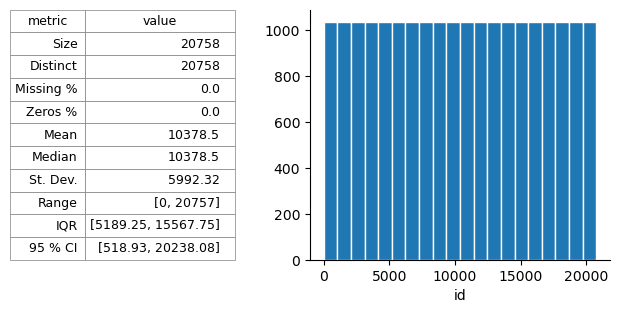

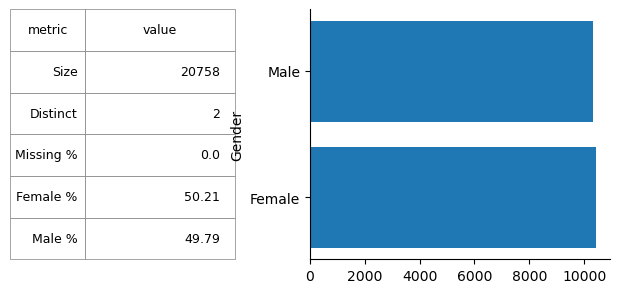

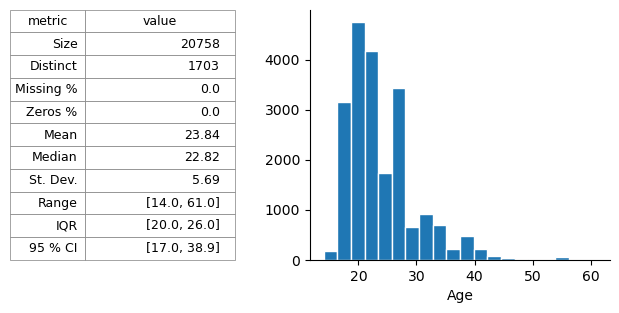

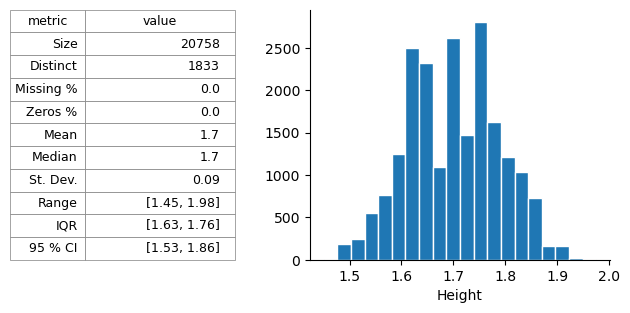

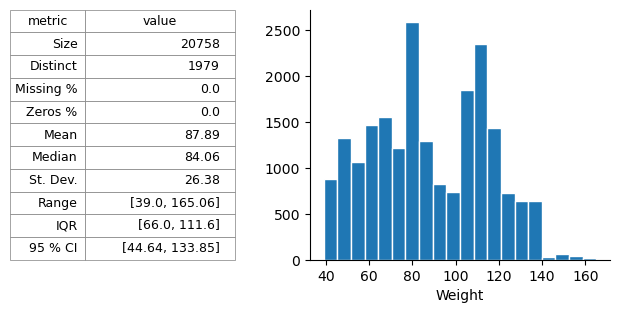

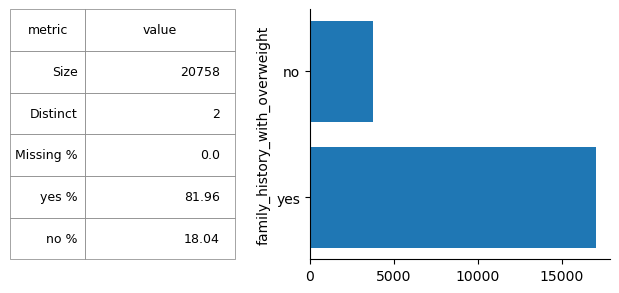

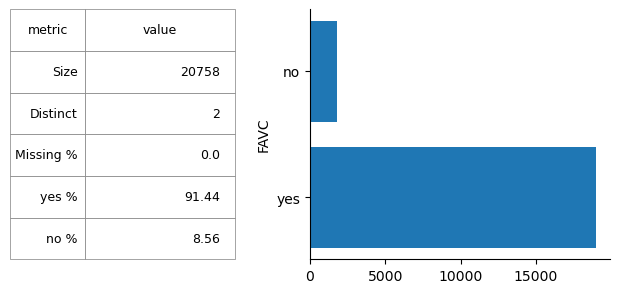

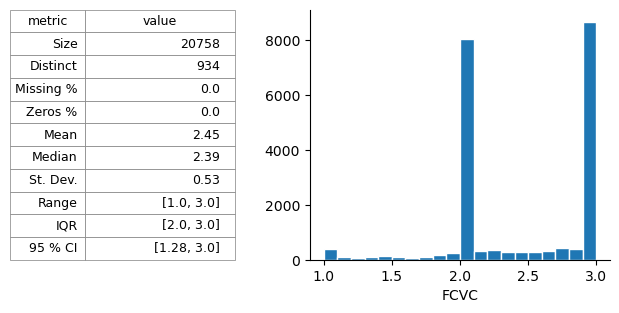

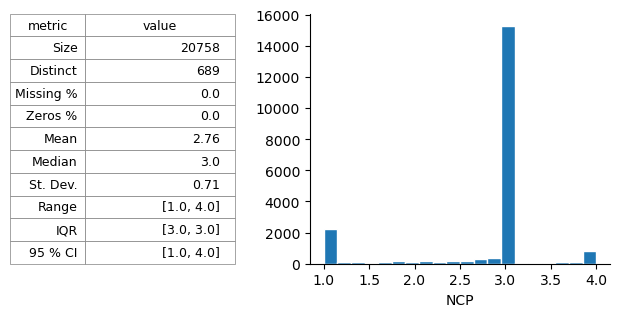

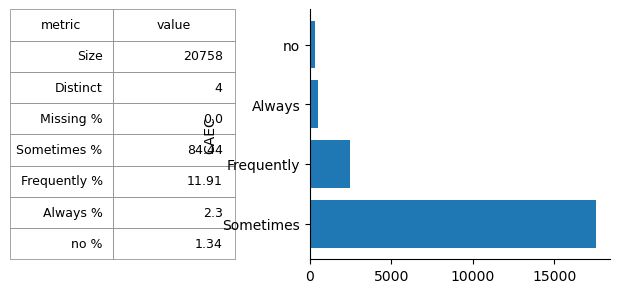

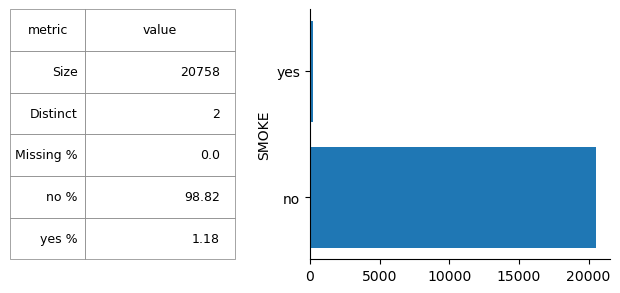

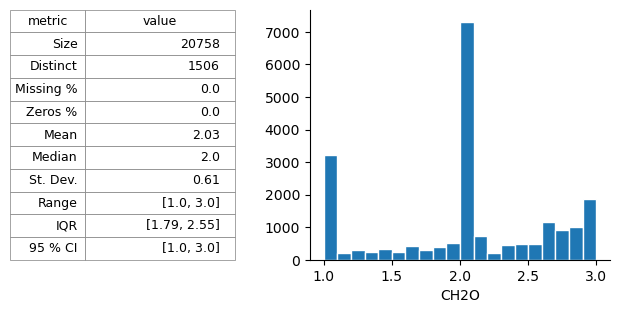

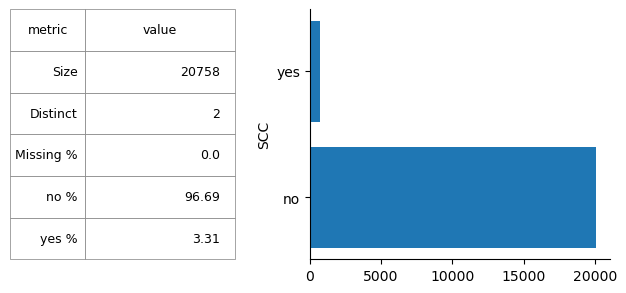

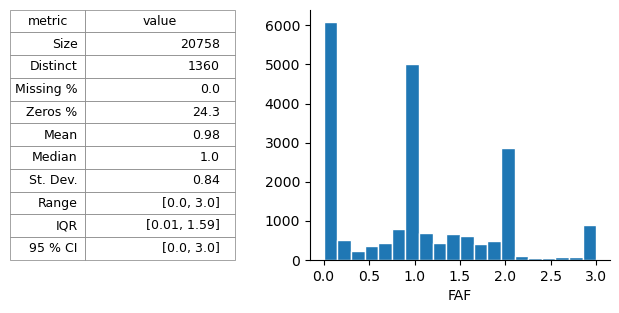

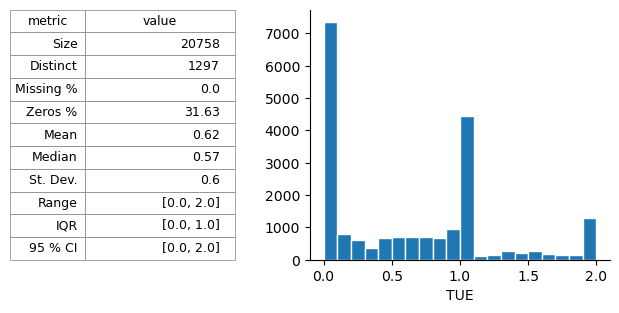

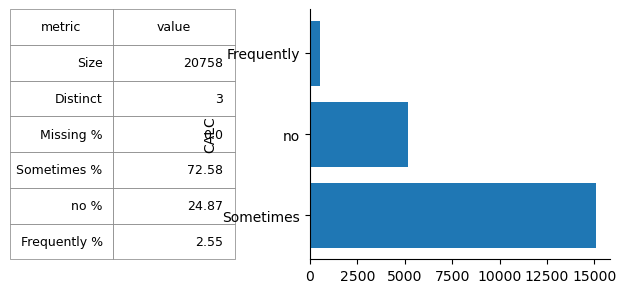

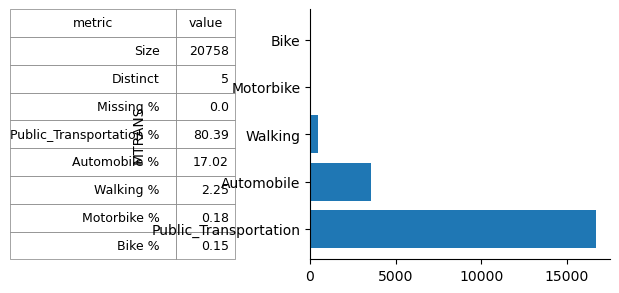

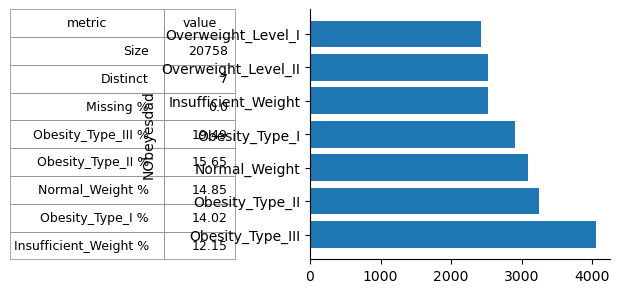

In [131]:
summarize_data(train_df)

In [132]:
weight_group = {
    "Insufficient_Weight":0,
    "Normal_Weight":1,
    "Overweight_Level_I":2,
    "Overweight_Level_II":3,
    "Obesity_Type_I":4,
    "Obesity_Type_II":5,
    "Obesity_Type_III":6,
}
weight_edcoder = {
    val: key for key, val in weight_group.items()
}

train_df['NObeyesdad'] = train_df['NObeyesdad'].map(weight_group)

### XY correlations

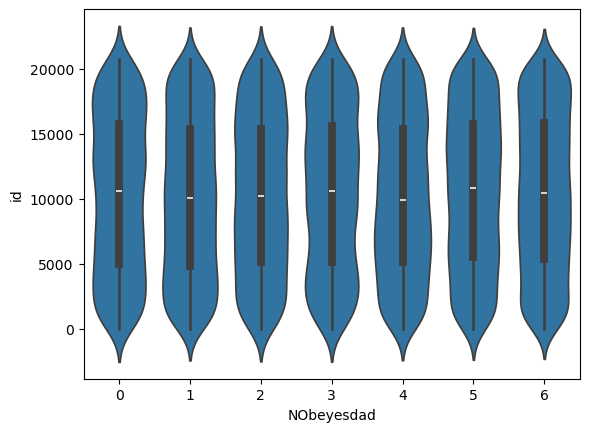

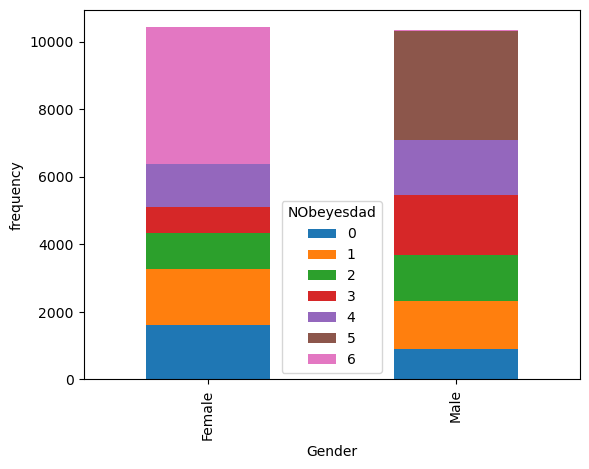

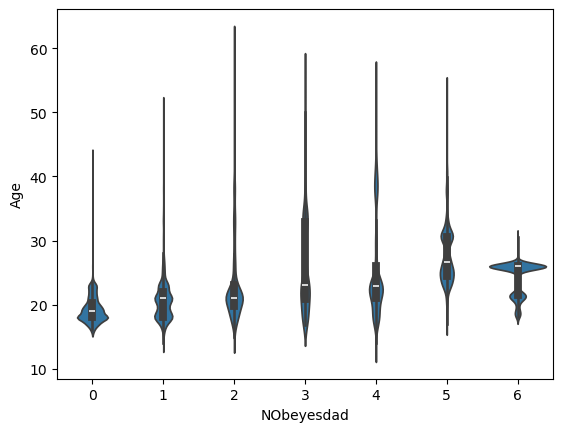

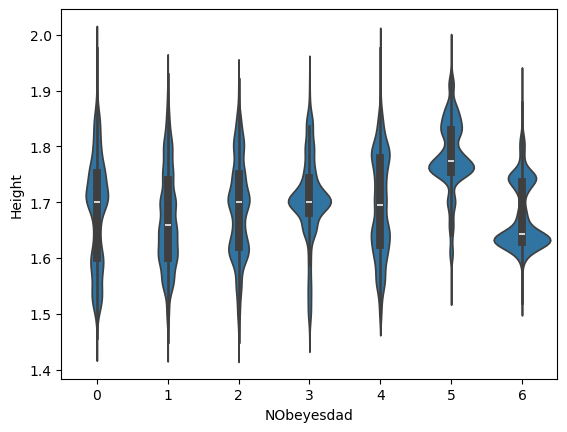

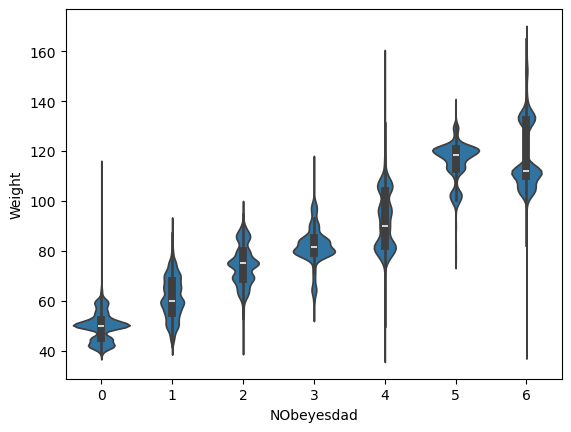

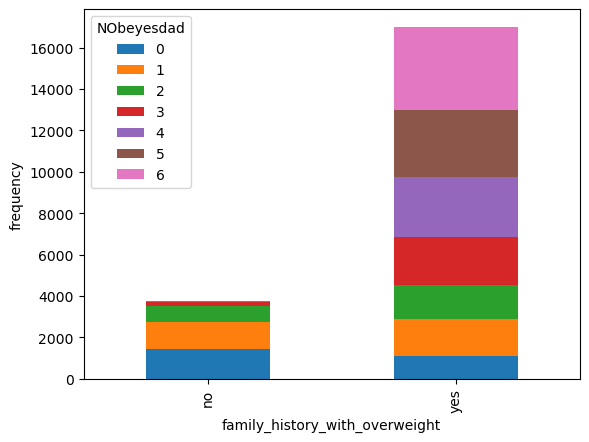

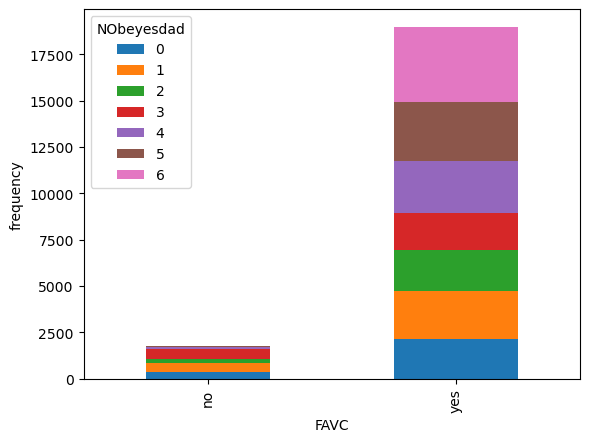

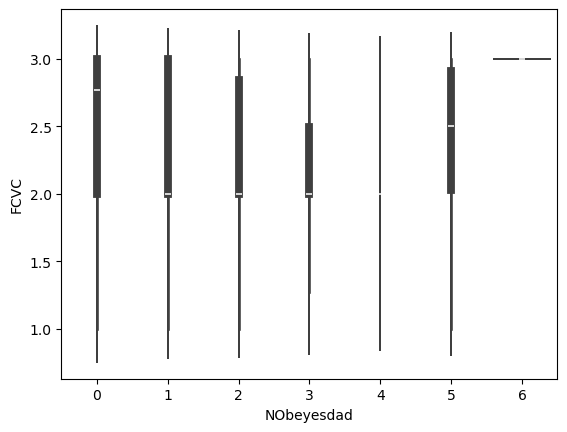

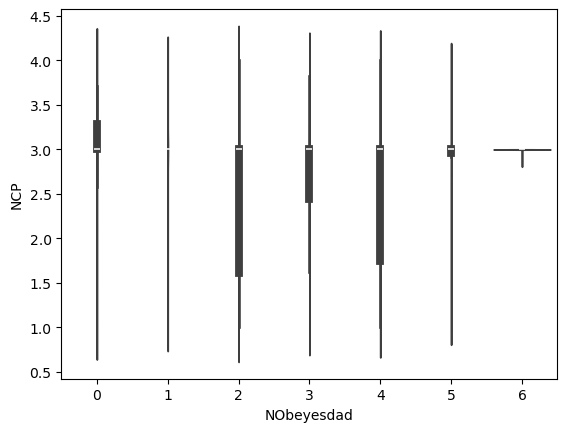

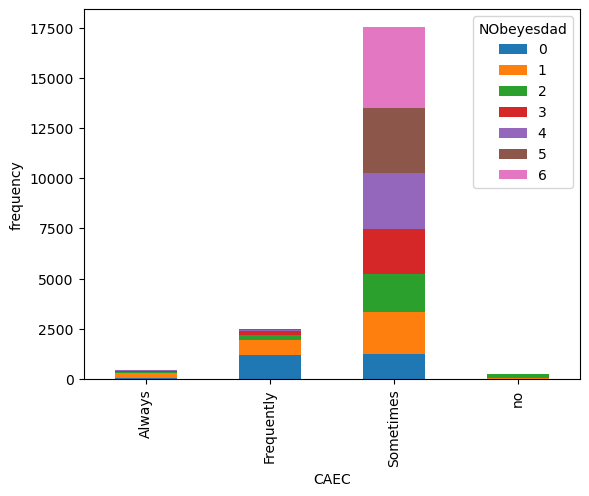

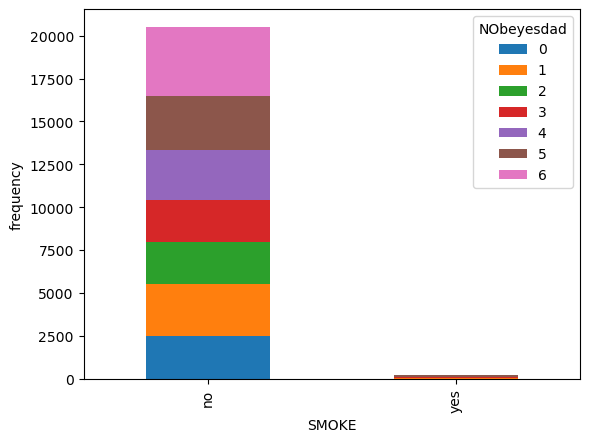

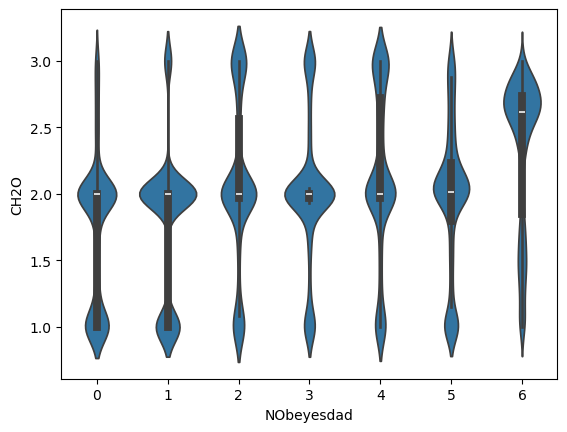

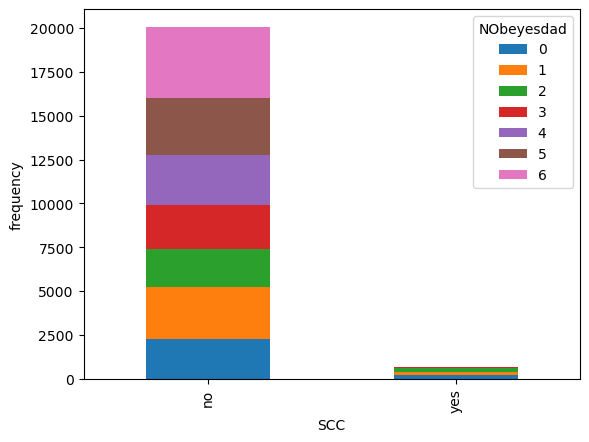

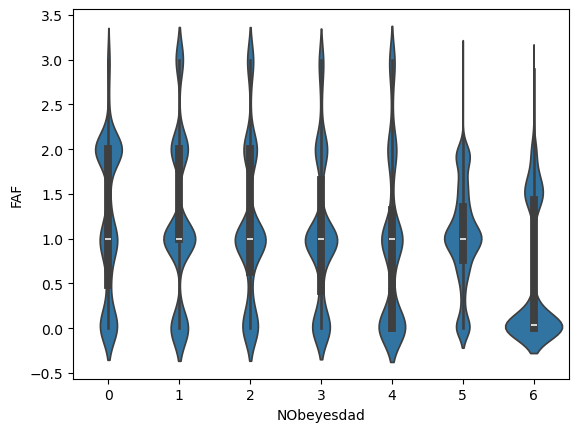

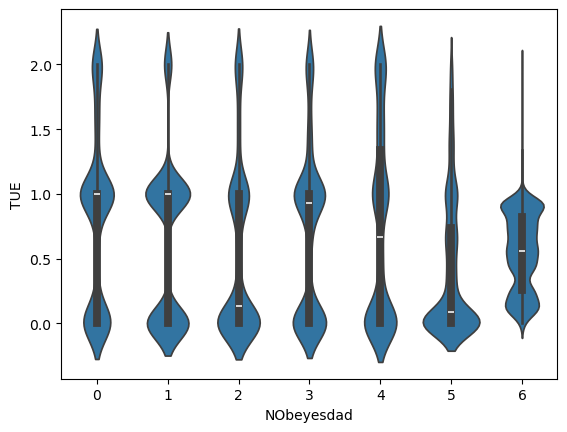

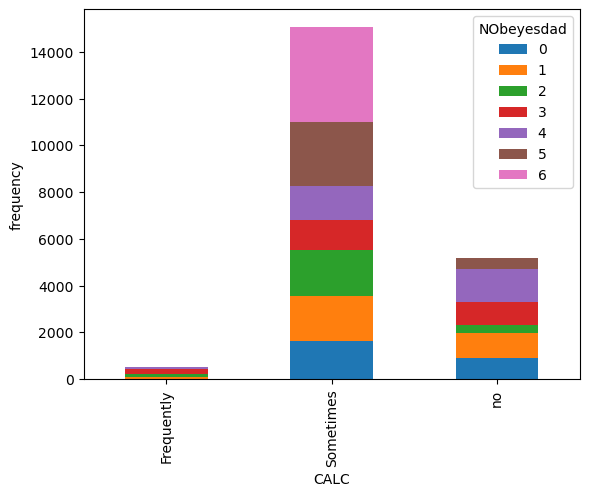

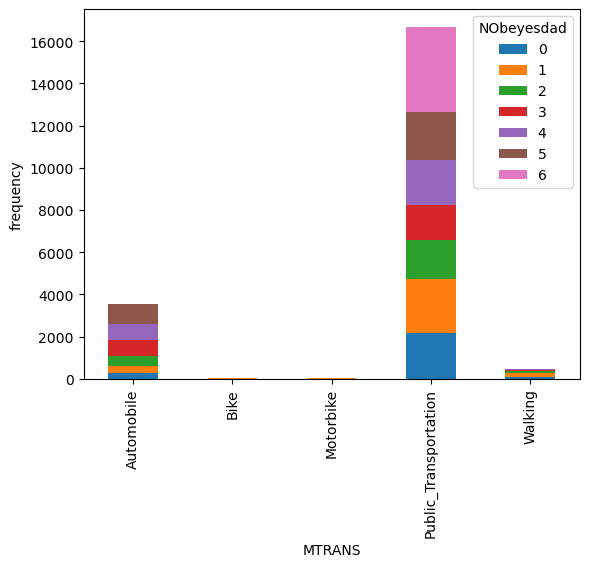

In [133]:
target = train_df.columns[-1]
for col, dtype in data_schema.items():
    if col == target:
        continue
    if dtype != "object":
        xy_violinplot(train_df, target, col)
    else:
        xy_barplot(train_df, target, [col])

### Feature Engineering

In [134]:
train_df.drop(['id'], axis=1, inplace=True)
test_df.drop(['id'], axis=1, inplace=True)

- BMI
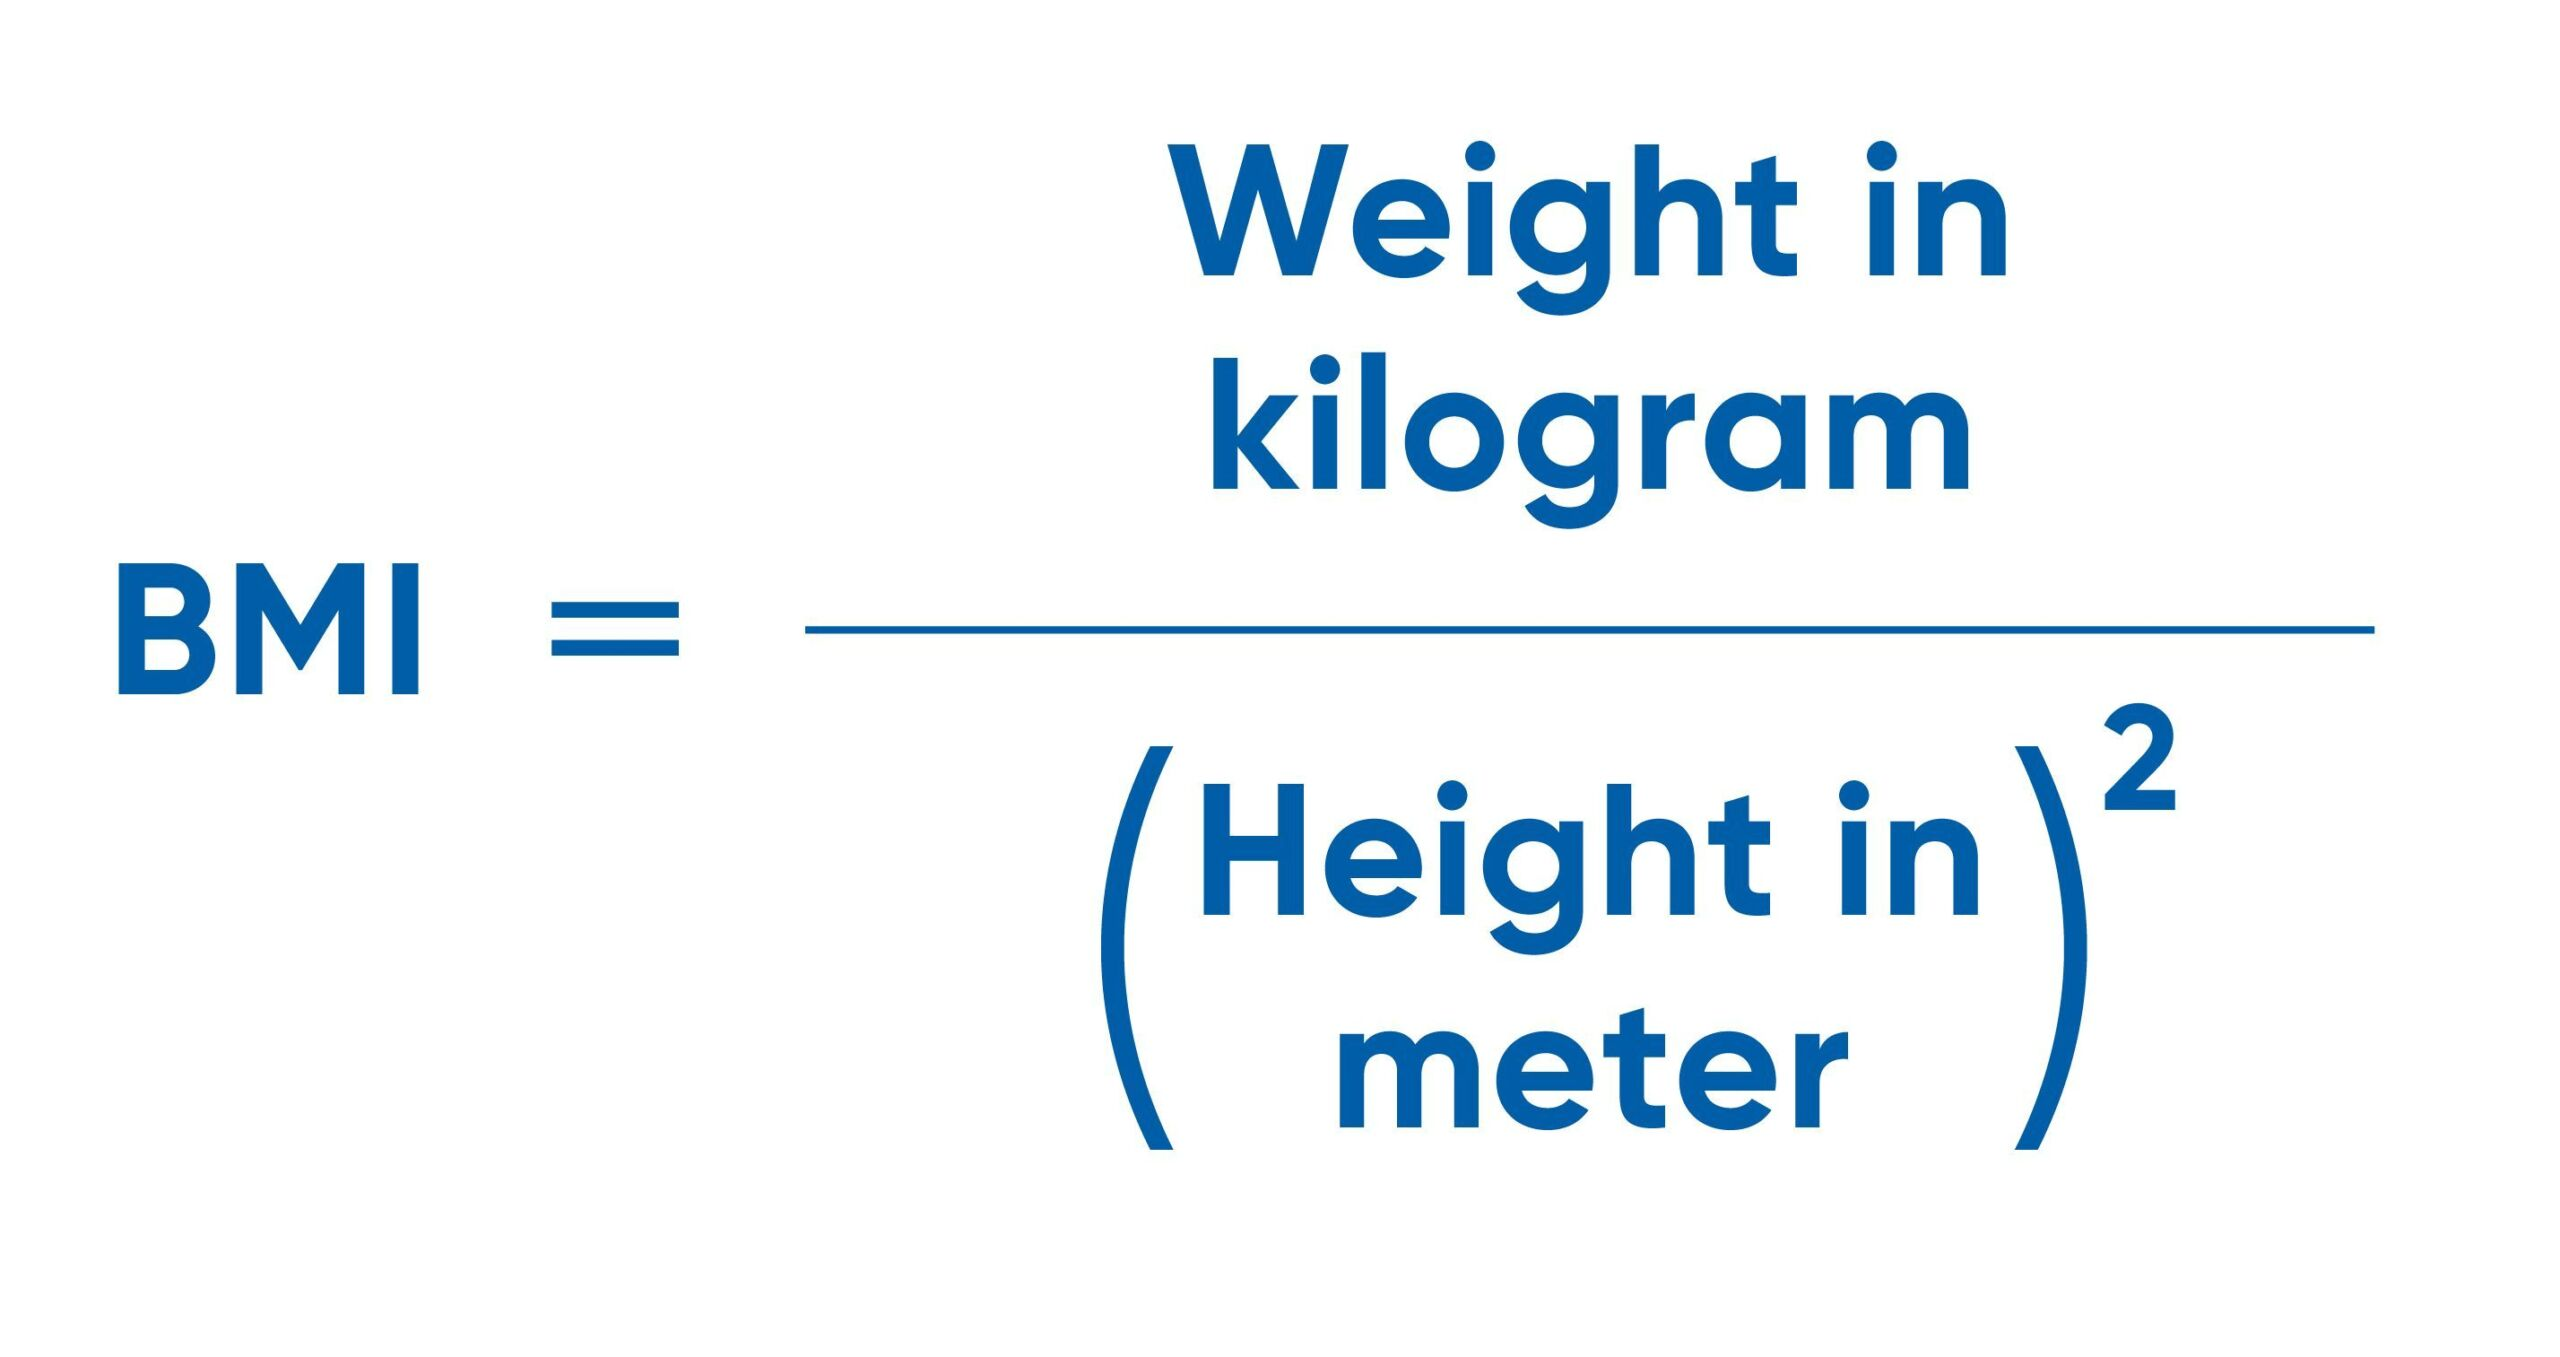

In [135]:
def bmi(h, w):
    return w/(h**2)

no_col = train_df.shape[1]-1
train_df.insert(no_col, 'bmi', bmi(train_df['Height'], train_df['Weight']))
test_df.insert(no_col, 'bmi', bmi(test_df['Height'], test_df['Weight']))

- Age buckets

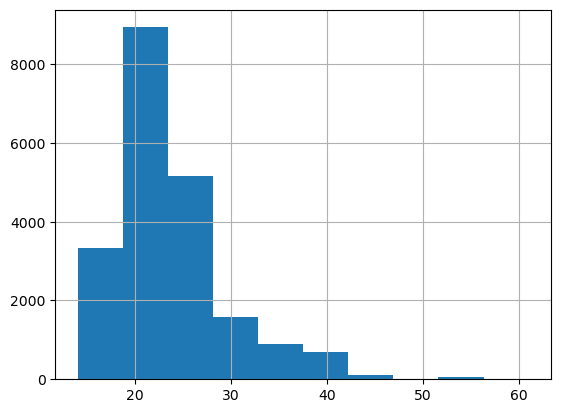

In [136]:
train_df['Age'].hist()
age_range = {
    '20-25': [20, 25],
    '25-35': [25, 35],
    '35-65': [35, 65],
    '+65': [65, 100]
}
for key, val in age_range.items():
    group = 1*((train_df['Age'].values>=val[0]) &
                 (train_df['Age'].values<=val[1]))
    no_col = train_df.shape[1]-1
    train_df.insert(no_col, key, group)

    group = 1*((test_df['Age'].values>=val[0]) &
                 (test_df['Age'].values<=val[1]))
    test_df.insert(no_col, key, group)

- Decimal to Integer

In [137]:
train_df['Height'] = (train_df['Height'].values*100).astype('int')
train_df['Weight'] = train_df['Weight'].values.astype('int')

test_df['Height'] = (test_df['Height'].values*100).astype('int')
test_df['Weight'] = test_df['Weight'].values.astype('int')

- encoder:
    - 'Gender'
    - 'family_history_with_overweight'
    - 'FAVC'
    - 'CAEC'
    - 'SMOKE'
    - 'SCC'
    - 'CALC'
    - 'MTRANS'

In [138]:
x = train_df.iloc[:,:-1].values
y = train_df.iloc[:,-1].values
columns = list(train_df.columns)[:-1]

x_test = test_df.iloc[:,:-1].values

gender_en = LabelEncoder()
col_id = columns.index('Gender')
x[:,col_id] = gender_en.fit_transform(x[:,col_id])
x_test[:,col_id] = gender_en.transform(x_test[:,col_id])


encoded_features = ['family_history_with_overweight',
                    'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

one_hat_columns = [columns.index(f) for f in encoded_features]
one_hat_encoder = ColumnTransformer(
        transformers= [
            ("one_hat_en", 
            OneHotEncoder(handle_unknown='ignore', sparse=False),
            one_hat_columns)
        ],
        remainder = 'passthrough'
        )
encoded_x = one_hat_encoder.fit_transform(x)
x_test = one_hat_encoder.transform(x_test)

features =[]

for name in one_hat_encoder.get_feature_names_out():
    if 'x' not in name:
        continue
    f = name.split('x')[1]
    if '_' in f:
        n,v = f.split('_')[0:2]
        n = int(n)
        f = "{}={}".format(columns[n],v)
    else:
        n = int(f)
        f = columns[n]
    features.append(f)
    print("{} -> {}".format(name, f))
ALL_FEATURES = features

one_hat_en__x4_no -> family_history_with_overweight=no
one_hat_en__x4_yes -> family_history_with_overweight=yes
one_hat_en__x5_no -> FAVC=no
one_hat_en__x5_yes -> FAVC=yes
one_hat_en__x8_Always -> CAEC=Always
one_hat_en__x8_Frequently -> CAEC=Frequently
one_hat_en__x8_Sometimes -> CAEC=Sometimes
one_hat_en__x8_no -> CAEC=no
one_hat_en__x9_no -> SMOKE=no
one_hat_en__x9_yes -> SMOKE=yes
one_hat_en__x11_no -> SCC=no
one_hat_en__x11_yes -> SCC=yes
one_hat_en__x14_Frequently -> CALC=Frequently
one_hat_en__x14_Sometimes -> CALC=Sometimes
one_hat_en__x14_no -> CALC=no
one_hat_en__x15_Automobile -> MTRANS=Automobile
one_hat_en__x15_Bike -> MTRANS=Bike
one_hat_en__x15_Motorbike -> MTRANS=Motorbike
one_hat_en__x15_Public_Transportation -> MTRANS=Public
one_hat_en__x15_Walking -> MTRANS=Walking
remainder__x0 -> Gender
remainder__x1 -> Age
remainder__x2 -> Height
remainder__x3 -> Weight
remainder__x6 -> FCVC
remainder__x7 -> NCP
remainder__x10 -> CH2O
remainder__x12 -> FAF
remainder__x13 -> TUE
re

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [139]:
cols = ['family_history_with_overweight=yes',
    'FAVC=yes',
    'CAEC=Always',
    'CAEC=Frequently',
    'CAEC=Sometimes',
    'SMOKE=yes',
    'SCC=yes',
    'CALC=Frequently',
    'CALC=Sometimes',
    'MTRANS=Automobile',
    'MTRANS=Bike',
    'MTRANS=Motorbike',
    'MTRANS=Public',
    'Gender',
    'Age',
    'Height',
    'Weight',
    'FCVC',
    'NCP',
    'CH2O',
    'FAF',
    'TUE',
    '20-25',
    '+65']
interactions = []
for i, c1 in enumerate(cols):
    interactions.append(['*', c1, c1])
    for c2 in cols[i+1:]:
        interactions.append(['*', c1, c2])
        interactions.append(['/', c1, c2])

interactions

[['*',
  'family_history_with_overweight=yes',
  'family_history_with_overweight=yes'],
 ['*', 'family_history_with_overweight=yes', 'FAVC=yes'],
 ['/', 'family_history_with_overweight=yes', 'FAVC=yes'],
 ['*', 'family_history_with_overweight=yes', 'CAEC=Always'],
 ['/', 'family_history_with_overweight=yes', 'CAEC=Always'],
 ['*', 'family_history_with_overweight=yes', 'CAEC=Frequently'],
 ['/', 'family_history_with_overweight=yes', 'CAEC=Frequently'],
 ['*', 'family_history_with_overweight=yes', 'CAEC=Sometimes'],
 ['/', 'family_history_with_overweight=yes', 'CAEC=Sometimes'],
 ['*', 'family_history_with_overweight=yes', 'SMOKE=yes'],
 ['/', 'family_history_with_overweight=yes', 'SMOKE=yes'],
 ['*', 'family_history_with_overweight=yes', 'SCC=yes'],
 ['/', 'family_history_with_overweight=yes', 'SCC=yes'],
 ['*', 'family_history_with_overweight=yes', 'CALC=Frequently'],
 ['/', 'family_history_with_overweight=yes', 'CALC=Frequently'],
 ['*', 'family_history_with_overweight=yes', 'CALC=Som

In [140]:
sc = MinMaxScaler()
x_scaled = sc.fit_transform(encoded_x)
x_test = sc.transform(x_test)

x_copy = x_scaled.copy()
feature_copy = ALL_FEATURES.copy()
cols = [
 ['*', 'Height', 'Gender'],
 ['/', 'FAVC=yes','Gender'],
 ['/', 'MTRANS=Public','Gender'],
 ['/', 'family_history_with_overweight=yes','FCVC'],
 ['*', 'Weight','FCVC'],
 ['/', 'family_history_with_overweight=yes','Weight'],
 ['/', 'Height','Weight'],
 ['/', 'Weight','+65'],
 ['/', 'FAVC=yes','Weight'],
 ['*', 'Weight','Weight'],
 ['*', 'Height','Height'],
]

for s, f1, f2 in cols:
        i = ALL_FEATURES.index(f1)
        j = ALL_FEATURES.index(f2)
        if s=='*':
                a = x_copy[:, i] * x_copy[:, j]
                b = x_test[:, i] * x_test[:, j]
                
        else:
                a = x_copy[:, i] / (0.0001+x_copy[:, j])
                b = x_test[:, i] / (0.0001+x_test[:, j])

        feature_copy.append("{}{}{}".format(f1, s, f2))
        x_copy = np.column_stack((x_copy, a))
        x_test = np.column_stack((x_test, b))


print(x_copy.shape, x_test.shape)


(20758, 45) (13840, 45)


- Feature Correlations

Top 20 highly correlated features:
                                      Row                             Column  \
843                           Weight/+65                             Weight   
5                               FAVC=yes                            FAVC=no   
44                             SMOKE=yes                           SMOKE=no   
0     family_history_with_overweight=yes  family_history_with_overweight=no   
65                               SCC=yes                             SCC=no   
968                        Height*Height                             Height   
944                        Weight*Weight                         Weight/+65   
926                        Weight*Weight                             Weight   
1019                          NObeyesdad                                bmi   
581                        Height*Gender                             Gender   
429                                  bmi                             Weight   
849             

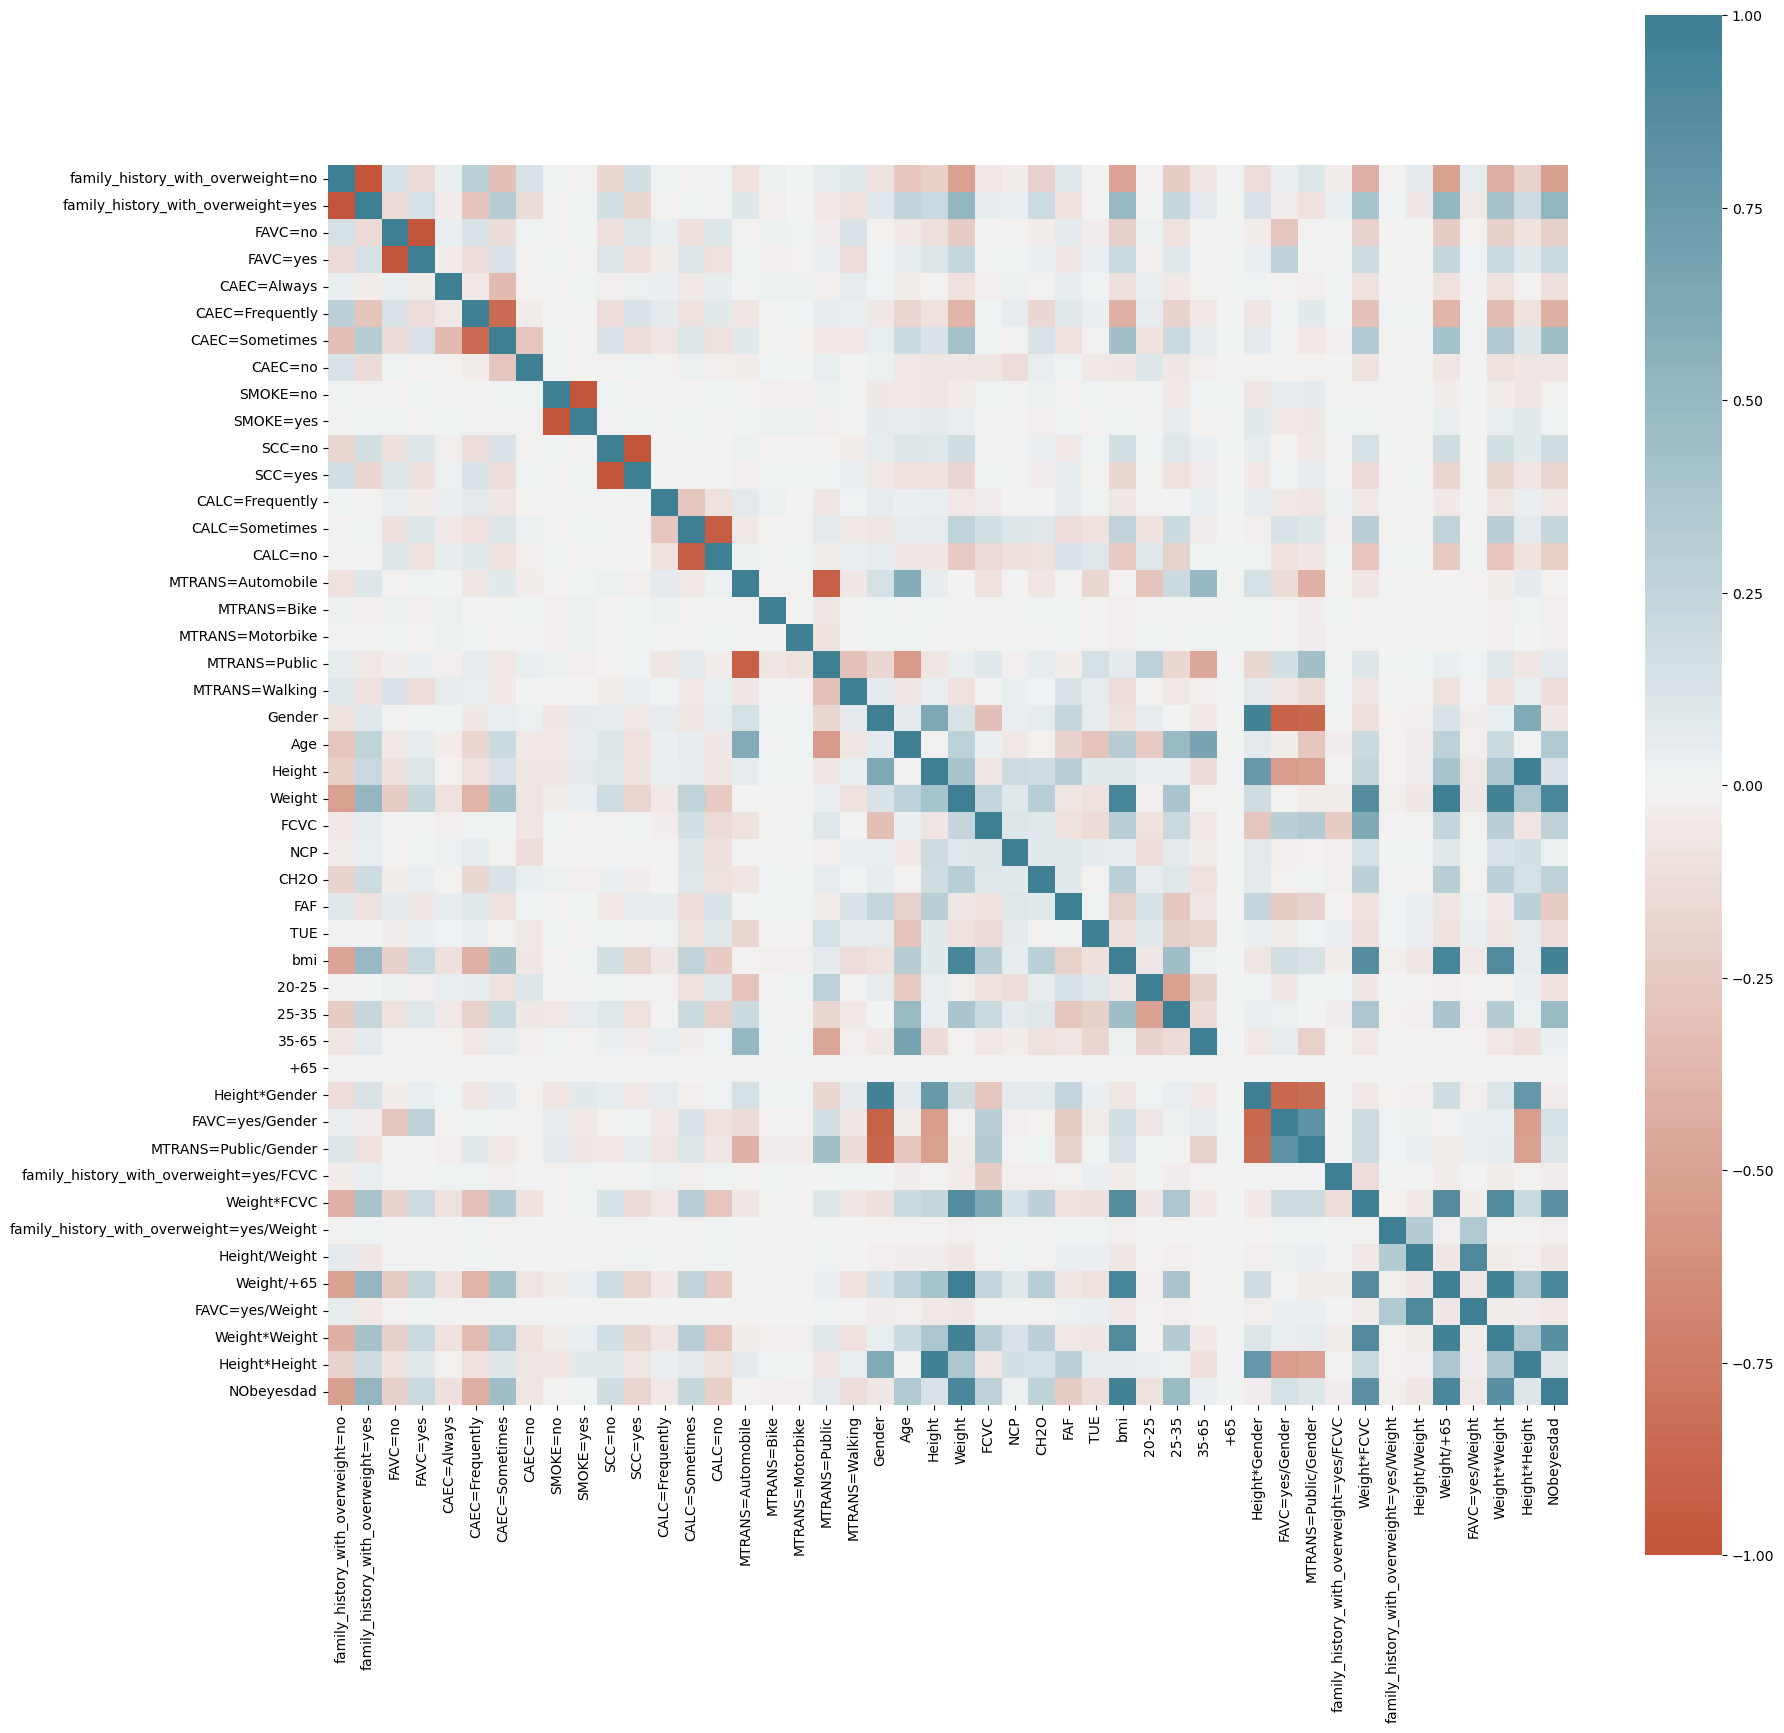

In [141]:
import seaborn as sns

copy_df = pd.DataFrame(x_copy.astype('float'),columns=feature_copy)
copy_df['NObeyesdad'] = y

corr = copy_df.corr().fillna(0)
fig,ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

is_lower_triangle = 1- np.triu(np.ones(corr.shape)).astype('bool')
df = corr.where(is_lower_triangle==1)
df = df.stack().reset_index()
df.columns = ['Row','Column','value']

df['value'] = np.abs(df['value'].values)
df.sort_values(by='value', ascending=False, inplace=True)

print("Top 20 highly correlated features:\n",
    df.head(20))

print("\nTop 20 features correlated to Y :\n",
    df.query('`Row`=="NObeyesdad"').head(20))

- Drop Correlated features

In [142]:
y_col = 'NObeyesdad'
threshold = 0.995

correlated_feautres = set()
seen_features = set()
for i, row in df.iterrows():
    if row['Row']== y_col or row['Column'] == y_col:
        continue

    if row['value']<threshold or \
        row['Row']== row['Column']:
        continue
    if row['Row'] in seen_features or\
        row['Column'] in seen_features:
         continue
    seen_features.add(row['Row'])
    seen_features.add(row['Column'])
    if  row['Row'] not in correlated_feautres:
        correlated_feautres.add(row['Column'])

is_correlated = []

for i,f in enumerate(feature_copy):
    if f not in correlated_feautres:
        is_correlated.append(i)
feature_copy = list(np.array(feature_copy)[is_correlated])
x_copy = x_copy[:,is_correlated]
x_test = x_test[:,is_correlated]
feature_copy

['family_history_with_overweight=yes',
 'FAVC=yes',
 'CAEC=Always',
 'CAEC=Frequently',
 'CAEC=Sometimes',
 'CAEC=no',
 'SMOKE=yes',
 'SCC=yes',
 'CALC=Frequently',
 'CALC=Sometimes',
 'CALC=no',
 'MTRANS=Automobile',
 'MTRANS=Bike',
 'MTRANS=Motorbike',
 'MTRANS=Public',
 'MTRANS=Walking',
 'Gender',
 'Age',
 'Height',
 'FCVC',
 'NCP',
 'CH2O',
 'FAF',
 'TUE',
 'bmi',
 '20-25',
 '25-35',
 '35-65',
 '+65',
 'Height*Gender',
 'FAVC=yes/Gender',
 'MTRANS=Public/Gender',
 'family_history_with_overweight=yes/FCVC',
 'Weight*FCVC',
 'family_history_with_overweight=yes/Weight',
 'Height/Weight',
 'Weight/+65',
 'FAVC=yes/Weight',
 'Weight*Weight',
 'Height*Height']

- Feature Importance

TOP 30 important features
                                      feature     score
31                       MTRANS=Public/Gender  0.255976
30                            FAVC=yes/Gender  0.135209
24                                        bmi  0.106747
36                                 Weight/+65  0.099121
33                                Weight*FCVC  0.047697
32    family_history_with_overweight=yes/FCVC  0.045165
34  family_history_with_overweight=yes/Weight  0.043128
35                              Height/Weight  0.028757
37                            FAVC=yes/Weight  0.027444
26                                      25-35  0.023916
10                                    CALC=no  0.013764
5                                     CAEC=no  0.013740
1                                    FAVC=yes  0.013414
16                                     Gender  0.011767
21                                       CH2O  0.011397
7                                     SCC=yes  0.010618
3                     

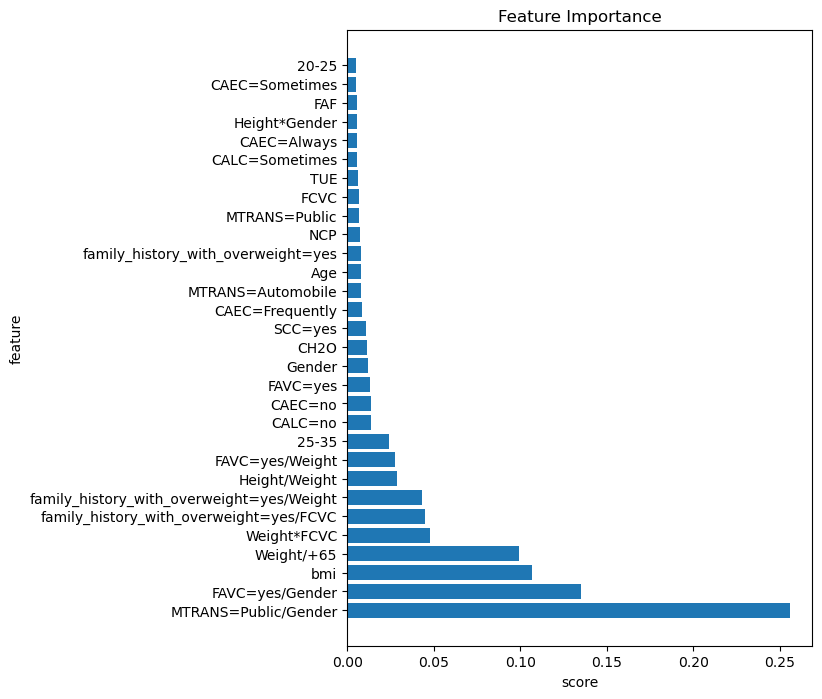

In [143]:
im_df = feature_importance(x_copy, y, feature_copy, is_classifer=True, top_k=30)

- Drop un-important features

In [144]:
unimportant_feautres= im_df.query('score < 0.002')['feature'].values

is_important = []

for i,f in enumerate(feature_copy):
    if f not in unimportant_feautres:
        is_important.append(i)
feature_copy = list(np.array(feature_copy)[is_important])
x_copy = x_copy[:,is_important]
x_test = x_test[:,is_important]

print(x_copy.shape, x_test.shape)

(20758, 35) (13840, 35)


## Model Development

(20758, 35) (20758,)


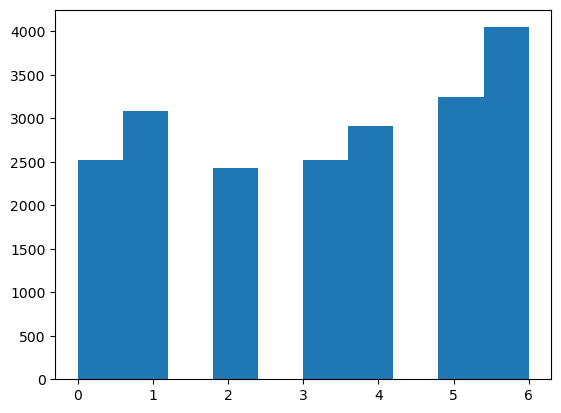

In [145]:
x_train, y_train = x_copy, y
print(x_train.shape, y_train.shape)

plt.hist(y_train)
plt.show()

- Find best model

In [146]:
def cross_validation(model, x, y, n_fold=5):
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=123)

    steps = [("norm", MinMaxScaler()), ("model", model)]
    model = Pipeline(steps=steps)
    res = []
    fold = 1
    for i_in, i_out in kfold.split(x, y):
        print(
            "training a {} (fold {} of {})...".format(key, fold, n_fold),
            end="\r",
        )
        model.fit(x[i_in, :], y[i_in])
        score = accuracy_score(y[i_out], model.predict(x[i_out, :]))
        print(
            "{} (fold {} of {}) Accuracy = {:.3f}".format(key, fold, n_fold, score),
            end="\r",
        )
        res.append(score)
        fold += 1
    print("Avg. Accuracy = {:.3f}".format(np.mean(res)))

In [147]:
models = {
    "lgb": LGBMClassifier(random_state=123, objective= 'multiclass_ova', metric='multi_logloss',verbose=0),
    "xgb": XGBClassifier(random_state=123, objective= 'multi:softmax'),
}
#for model in models.values():
#    cross_validation(model, x_train, y_train)

- Tune a model

In [148]:
from typing import Literal

def tune_a_classifier(
    model: Literal["rf", "xgb", "lgbm"],
    x: np.ndarray,
    y: np.array,
    random_search: bool = True,
    n_iter:int = 50,
    random_state: int = 123,
) -> [object, object]:
    """tune_a_model tunes an random forest or xgboost hyperparameters

    Parameters
    ----------
    model : str
        model type, can be one of ["rf", "xgb", "lgbm"]
    x : np.ndarray
        x data
    y : np.array
        y data
    random_search : bool, optional
        a toggle to switch random or grid search, by default True

    Returns
    -------
    [object, object]
        best_estimator and best_params
    """
    if model == "rf":
        grid = {
            "n_estimators": [20, 50, 100, 200, 300, 400, 600],
            "criterion": ["gini", "entropy"],
            "max_depth": [1, 5, 10, 25, 50, 75, 100],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "random_state": [random_state],
            "max_features": ["auto", "sqrt", "log2"],
            "bootstrap": [True, False],
            "class_weight": [None, "balanced", "balanced_subsample"],
        }
        estimator = RandomForestClassifier(random_state=random_state)
    elif model == "xgb":
        grid = {
            "learning_rate": [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02],
            "n_estimators": [300, 400, 600, 800, 1000],
            "max_depth": [1, 5, 10, 25, 50, 75, 100],
            "min_child_weight": [1, 3, 5, 10, 100],
            "gamma": [0, 0.1, 0.2, 0.3],
            "subsample": [0.4,0.5,0.6,0.7,0.8,1.0],
            "colsample_bytree": [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0],
            'reg_alpha': [0.001, 0.01, 0.1, 1, 10], 
            'reg_lambda': [0.001, 0.01, 0.1, 1, 10],
            "objective": ["multiclass_ova"],
            'random_state': [random_state],
            'tree_method':['hist'],
            }
        estimator = XGBClassifier(random_state=random_state)
    elif model == "lgbm":
        grid = {
        'random_state': [random_state],
        "n_estimators": [2000], 
        'num_classes': [7],
        'objective': ['multi:softmax'], 
        'metric': ['auc'], 
        'learning_rate': [0.006,0.008,0.01,0.014,0.017,0.02],
        'reg_alpha': [0.001, 0.01, 0.1, 1, 10], 
        'reg_lambda': [0.001, 0.01, 0.1, 1, 10],
        'num_leaves' : [3, 15, 31, 63, 127],
        'n_jobs': [-1],
        'colsample_bytree': [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0],
        'subsample': [0.4,0.5,0.6,0.7,0.8,1.0],
        'max_depth': [1, 10,20,100, -1],
        'min_child_samples': [20, 50, 100],
        "min_split_gain": [0.0,0.1,0.2,0.3],
        "boosting_type": ["gbdt", "dart", "goss"],
        }
        estimator = LGBMClassifier(random_state=random_state)
    else:
        print("Please define the model you want to tune first!")

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        scoring="multi_logloss",
        n_jobs=-1,
        cv=kfold,
        verbose=1,
    )
    if random_search:
        grid_search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=grid,
            n_iter=n_iter,
            cv=kfold,
            verbose=1,
            scoring="f1_macro",
            random_state=random_state,
            n_jobs=-1,
        )
    
    grid_search.fit(x, y)
    print(grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_

In [149]:
#lgbm_model, lgb_param = tune_a_classifier('lgbm',x_train[:2000], y_train[:2000], 
#                                            random_search=True)
lgbm_model = models['lgb']

In [150]:
lgbm_model.fit(x_train, y_train)

im_df = pd.DataFrame(
    {"feature": feature_copy, "score": lgbm_model.feature_importances_}
).sort_values(by="score", ascending=False)

display(im_df.head(20))


,feature,score
16,Age,2550
23,bmi,2085
21,FAF,1544
32,Height/Weight,1441
20,CH2O,1390
33,Weight/+65,1351
22,TUE,1289
30,Weight*FCVC,1247
31,family_history_with_overweight=yes/Weight,1063
19,NCP,1032


## Model Production

In [151]:
y_pred_test = lgbm_model.predict(x_test)

df = pd.DataFrame({
    'id': test_id,
    'NObeyesdad':y_pred_test
})
df['NObeyesdad'] = df['NObeyesdad'].map(weight_edcoder)
df.to_csv('submission.csv', index=False)

In [152]:
df2 = pd.read_csv('submission - 0.9.csv')
y_pred_test1 = df2['NObeyesdad'].map(weight_group).values
accuracy_score(y_pred_test, y_pred_test1)

0.983164739884393